In [1]:
pip install numpy gym torch stable-baselines3 matplotlib pettingzoo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 36.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque
from pettingzoo import ParallelEnv

# Multi-UAV Grid Environment
class MultiUAVGridEnv(ParallelEnv):
    def __init__(self, num_uavs=3, grid_size=5):
        super().__init__()

        self.num_uavs = num_uavs
        self.grid_size = grid_size
        self.state_size = self.grid_size * self.grid_size
        self.actions = [0, 1, 2, 3]  # Up, Down, Left, Right
        self.goal_state = (grid_size - 1, grid_size - 1)
        self.reset()

    def reset(self):
        """ Reset UAVs to their start positions """
        self.uav_positions = {i: (0, i) for i in range(self.num_uavs)}  # Different start points
        return {i: self.state_to_vector(self.uav_positions[i]) for i in range(self.num_uavs)}

    def state_to_vector(self, position):
        """ Convert (x, y) position to a one-hot encoded state vector """
        state = np.zeros(self.state_size)
        index = position[0] * self.grid_size + position[1]
        state[index] = 1
        return state

    def step(self, actions):
        """ Move UAVs based on actions and return new states, rewards, and done flags """
        rewards, next_states = {}, {}
        done = {i: False for i in range(self.num_uavs)}

        for i, action in actions.items():
            x, y = self.uav_positions[i]

            if action == 0 and x > 0:  # Move Up
                x -= 1
            elif action == 1 and x < self.grid_size - 1:  # Move Down
                x += 1
            elif action == 2 and y > 0:  # Move Left
                y -= 1
            elif action == 3 and y < self.grid_size - 1:  # Move Right
                y += 1

            self.uav_positions[i] = (x, y)
            rewards[i] = 10 if self.uav_positions[i] == self.goal_state else -1
            done[i] = self.uav_positions[i] == self.goal_state
            next_states[i] = self.state_to_vector(self.uav_positions[i])

        return next_states, rewards, done, {}

    def render(self, episode, trajectories):
        """ Visualize the UAV swarm movement in real-time """
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.grid(True)

        # Draw goal
        goal_rect = patches.Rectangle((self.goal_state[1] - 0.5, self.goal_state[0] - 0.5), 1, 1, linewidth=2, edgecolor='green', facecolor='lightgreen')
        ax.add_patch(goal_rect)
        ax.text(self.goal_state[1], self.goal_state[0], 'Goal', fontsize=12, ha='center', va='center')

        # Draw UAV trajectories
        colors = ['blue', 'red', 'orange']
        for i, trajectory in trajectories.items():
            for (x, y) in trajectory:
                ax.add_patch(patches.Circle((y, x), 0.2, color=colors[i]))

            # Draw final UAV position
            ax.add_patch(patches.Circle((self.uav_positions[i][1], self.uav_positions[i][0]), 0.3, color=colors[i]))
            ax.text(self.uav_positions[i][1], self.uav_positions[i][0], f'UAV-{i}', fontsize=8, ha='center', va='center', color='white')

        plt.title(f"Multi-UAV Swarm Movement (Episode {episode})")
        plt.show()


In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class MultiAgentDQN:
    def __init__(self, num_uavs, input_dim, output_dim):
        self.num_uavs = num_uavs
        self.agents = {i: DQN(input_dim, output_dim) for i in range(num_uavs)}
        self.optimizers = {i: optim.Adam(self.agents[i].parameters(), lr=0.001) for i in range(num_uavs)}
        self.memories = {i: deque(maxlen=1000) for i in range(num_uavs)}
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def select_action(self, agent_id, state):
        """ Choose an action using epsilon-greedy strategy """
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.agents[agent_id].fc3.out_features)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        return torch.argmax(self.agents[agent_id](state)).item()

    def train(self, batch_size=32):
        """ Train each agent using experience replay """
        for agent_id in range(self.num_uavs):
            if len(self.memories[agent_id]) < batch_size:
                continue
            batch = random.sample(self.memories[agent_id], batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.tensor(states, dtype=torch.float32)
            actions = torch.tensor(actions, dtype=torch.int64)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.tensor(next_states, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32)

            q_values = self.agents[agent_id](states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = self.agents[agent_id](next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, target_q_values)
            self.optimizers[agent_id].zero_grad()
            loss.backward()
            self.optimizers[agent_id].step()

    def update_epsilon(self):
        """ Reduce epsilon over time """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


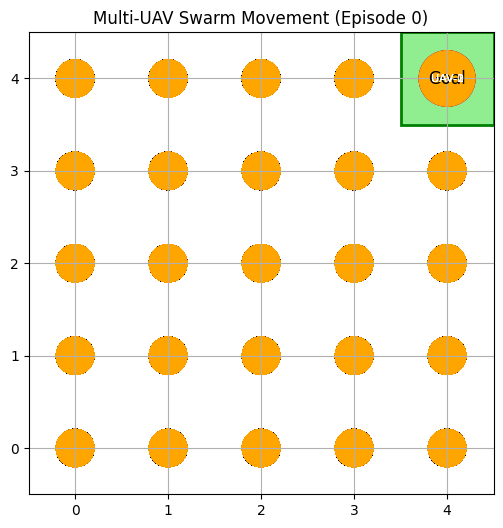

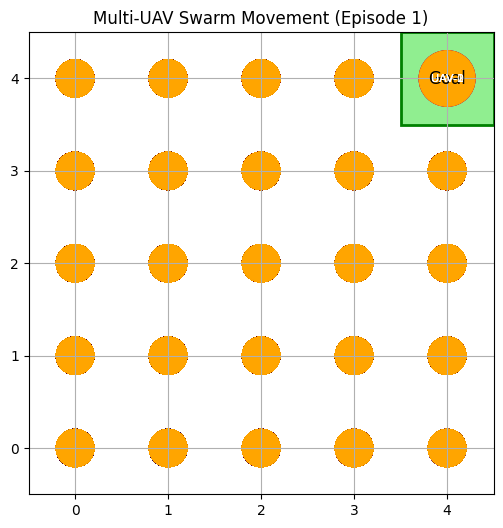

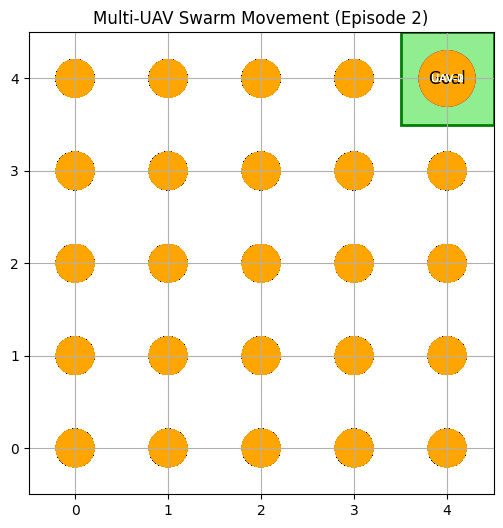

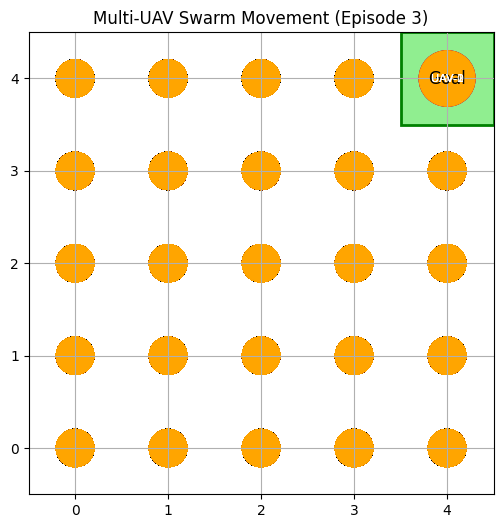

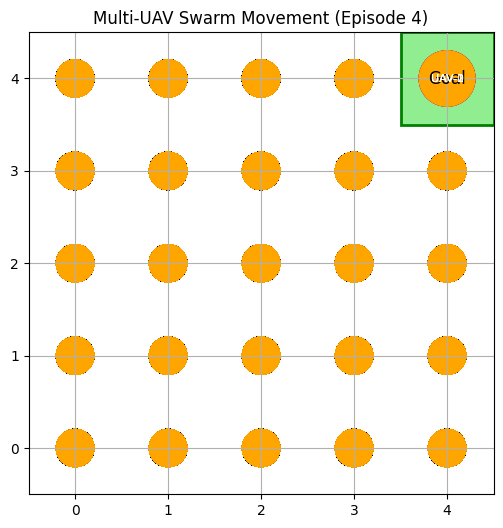

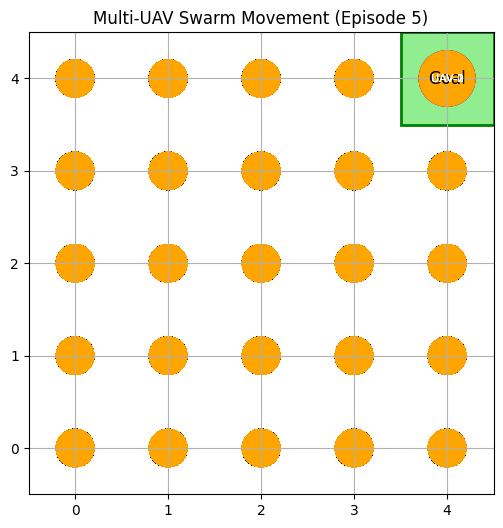

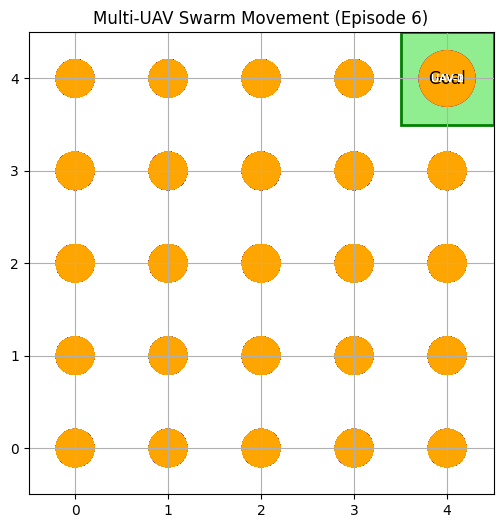

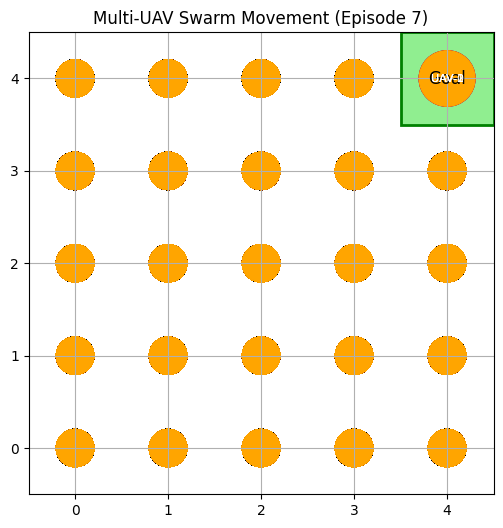

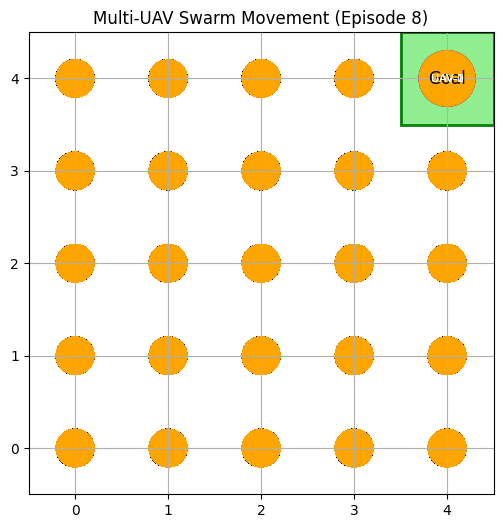

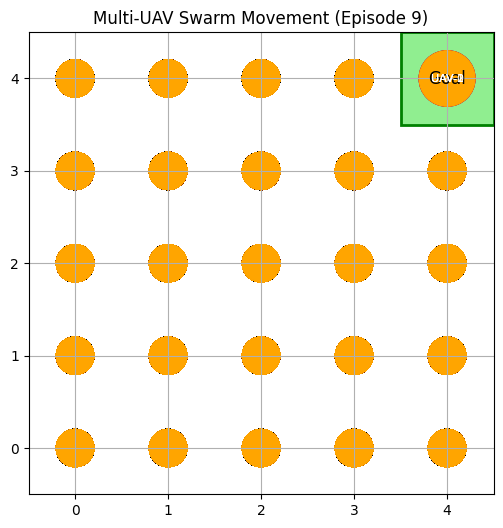

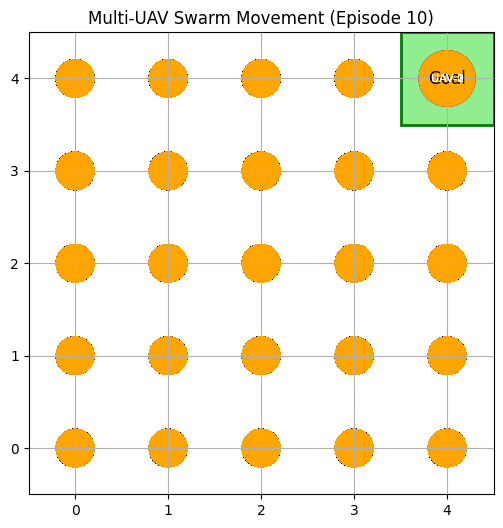

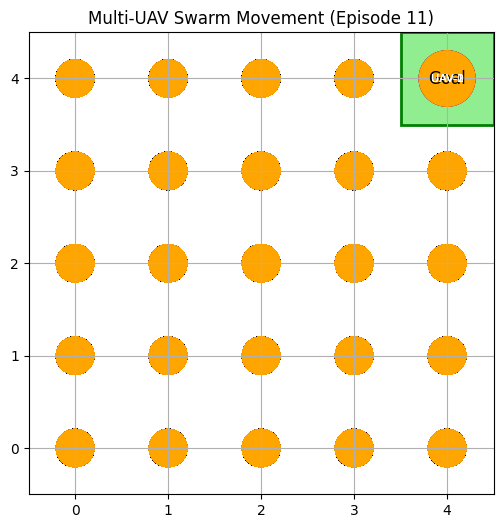

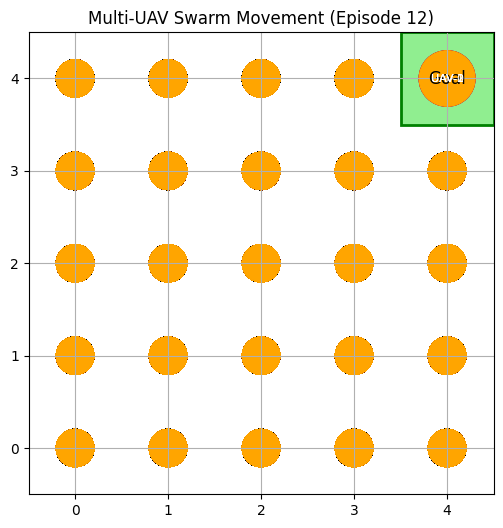

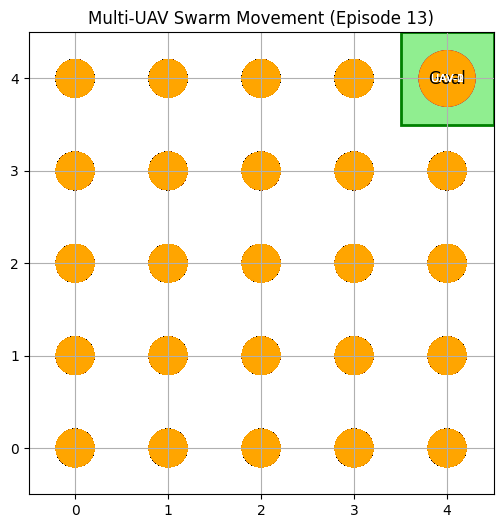

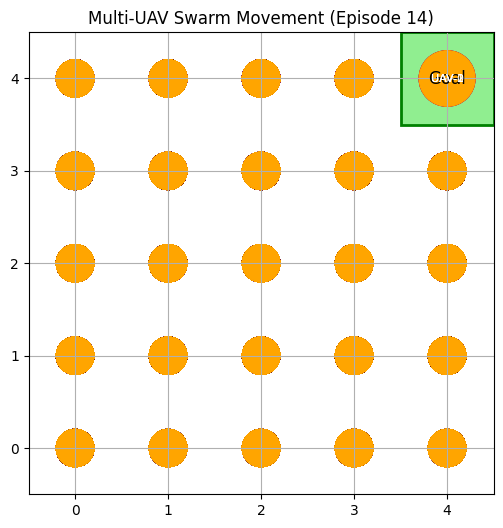

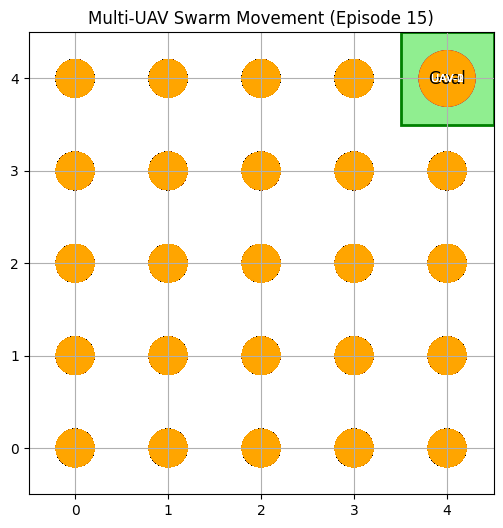

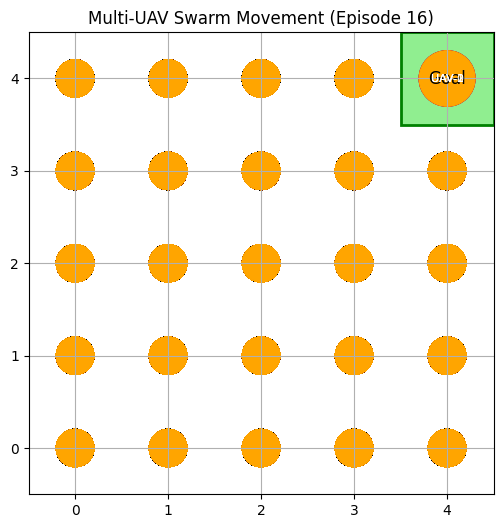

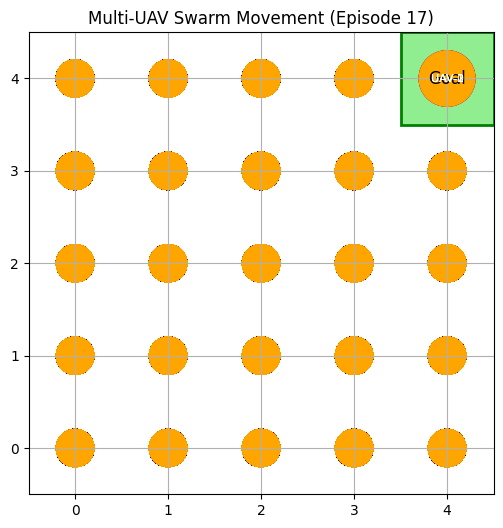

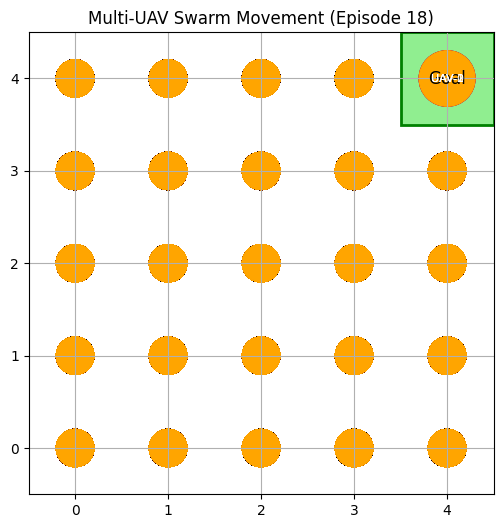

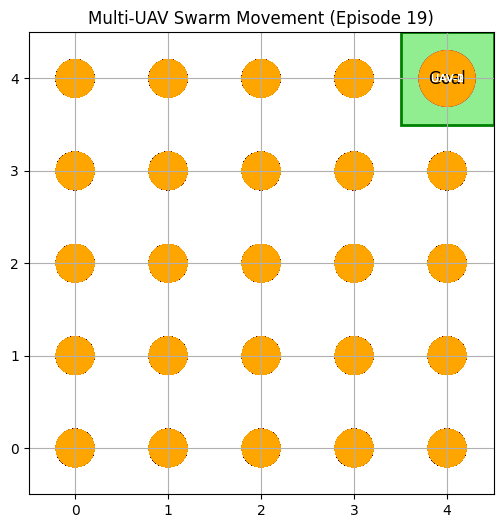

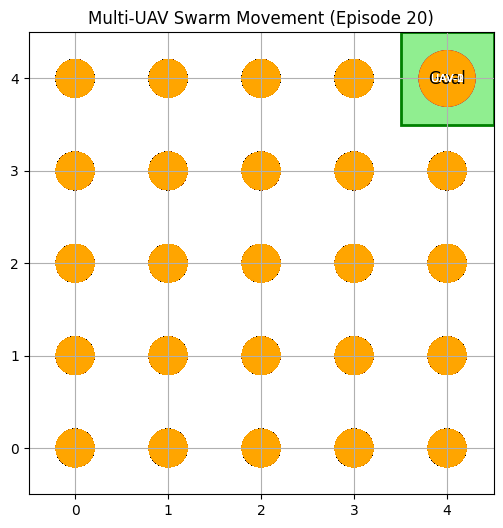

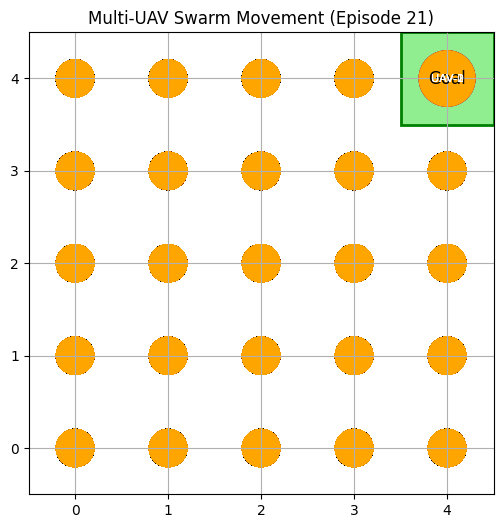

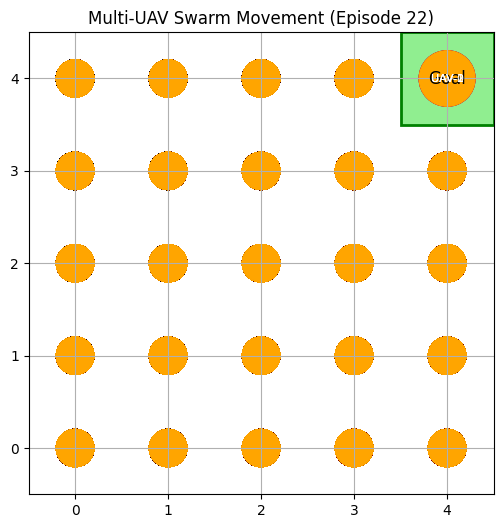

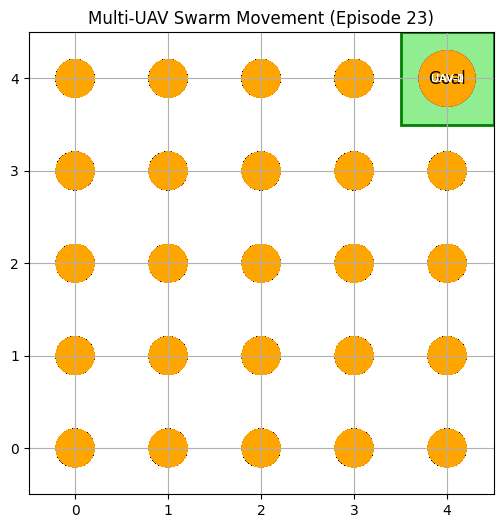

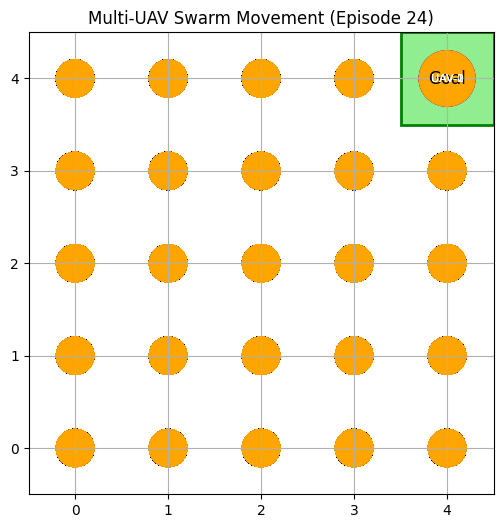

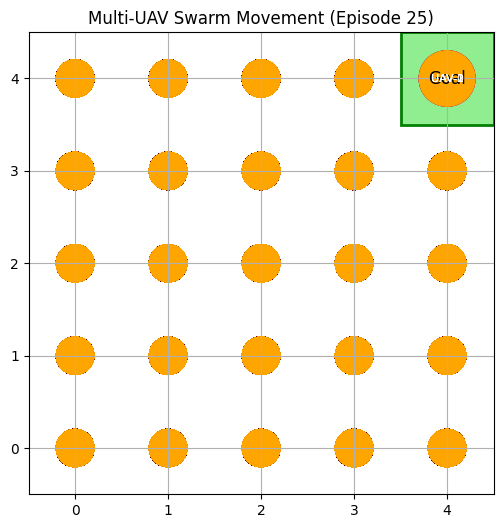

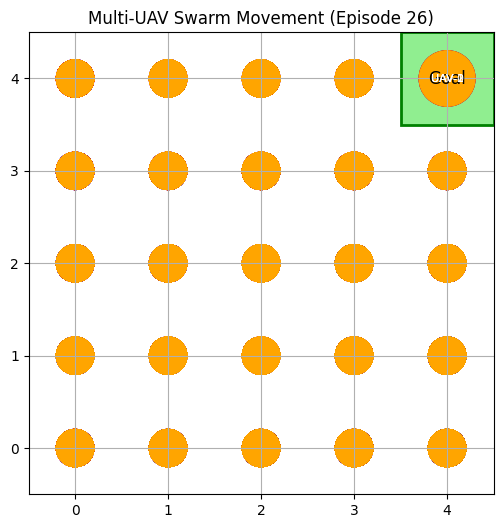

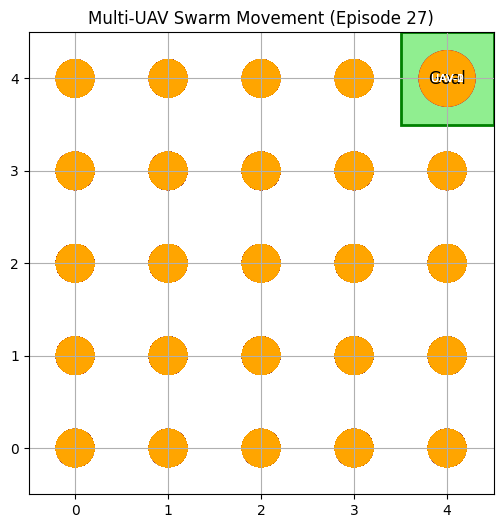

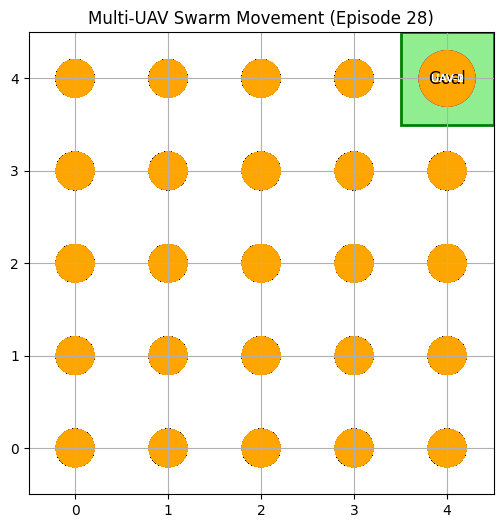

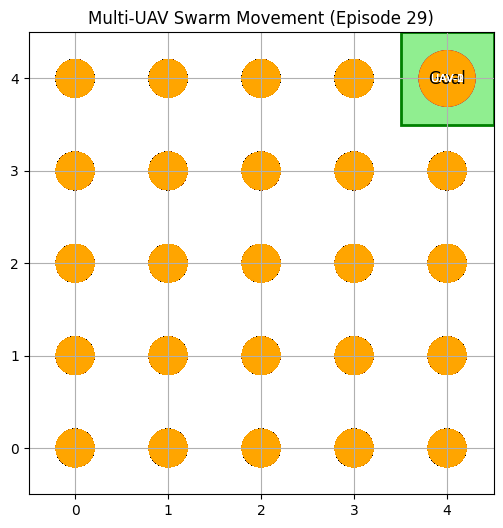

In [ ]:
env = MultiUAVGridEnv(num_uavs=3)
marl_agent = MultiAgentDQN(num_uavs=3, input_dim=env.state_size, output_dim=len(env.actions))

for episode in range(50):
    state = env.reset()
    done = {i: False for i in range(3)}
    trajectories = {i: [] for i in range(3)}

    while not all(done.values()):
        actions = {i: marl_agent.select_action(i, state[i]) for i in range(3)}
        next_state, rewards, done, _ = env.step(actions)
        for i in range(3):
            trajectories[i].append(env.uav_positions[i])

    env.render(episode, trajectories)
